# Checking on Test

## Bottle

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

# Free up memory
torch.cuda.empty_cache()
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader classes (same as before)
class VOCBottleClassification(Dataset):
    def __init__(self, root, year, image_set, transform=None):
        self.voc = torchvision.datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True,
                                transforms=lambda img, target: (transform(img), target))
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, target = self.voc[idx]
        objs = target['annotation']['object']
        if not isinstance(objs, list):
            objs = [objs]
        label = 1 if any(o['name'] == 'bottle' for o in objs) else 0
        img_id = target['annotation']['filename']
        return img, label, img_id

class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Data Loaders
num_workers = min(2, os.cpu_count() // 2)
train_ds = VOCBottleClassification(root='.', year='2008', image_set='train', transform=transform_train)
test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=num_workers)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


VIT base

In [4]:
# Vision Transformer Base (ViT_B_16) Model
from torchvision.models import vit_b_16, ViT_B_16_Weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 214MB/s]  
Epoch 1/5: 100%|██████████| 66/66 [01:08<00:00,  1.04s/it]


Epoch 1, Loss: 0.0144


Epoch 2/5: 100%|██████████| 66/66 [01:10<00:00,  1.07s/it]


Epoch 2, Loss: 0.0097


Epoch 3/5: 100%|██████████| 66/66 [01:12<00:00,  1.10s/it]


Epoch 3, Loss: 0.0062


Epoch 4/5: 100%|██████████| 66/66 [01:13<00:00,  1.12s/it]


Epoch 4, Loss: 0.0042


Epoch 5/5: 100%|██████████| 66/66 [01:14<00:00,  1.13s/it]

Epoch 5, Loss: 0.0043


test

Testing: 100%|██████████| 110/110 [01:04<00:00,  1.71it/s]


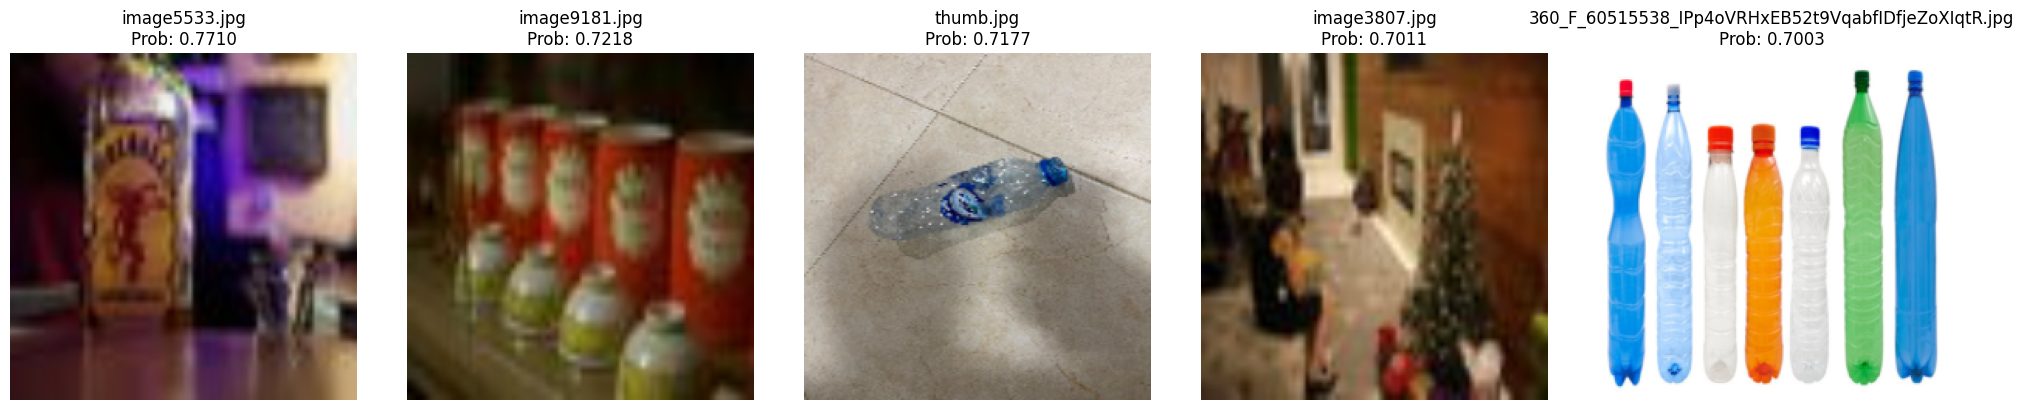


Top 5 predictions:
1. image5533.jpg - Probability: 0.7710
2. image9181.jpg - Probability: 0.7218
3. thumb.jpg - Probability: 0.7177
4. image3807.jpg - Probability: 0.7011
5. 360_F_60515538_IPp4oVRHxEB52t9VqabfIDfjeZoXIqtR.jpg - Probability: 0.7003


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from torchvision.models.vision_transformer import vit_b_16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model.eval()

# Testing on the new images
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array for easier handling
all_scores_np = np.array(all_scores)

# Get indices of top 5 highest probabilities
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Plot top 5 images
fig, axes = plt.subplots(1, min(5, len(top_indices)), figsize=(20, 4))
if len(top_indices) == 1:
    axes = [axes]  # Make it iterable if only one image

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print top 5 predictions
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

#### Resnet50

In [7]:
# ResNet50 Model
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/1: 100%|██████████| 66/66 [00:22<00:00,  2.90it/s]

Epoch 1, Loss: 0.0222


test

Testing: 100%|██████████| 110/110 [00:19<00:00,  5.62it/s]


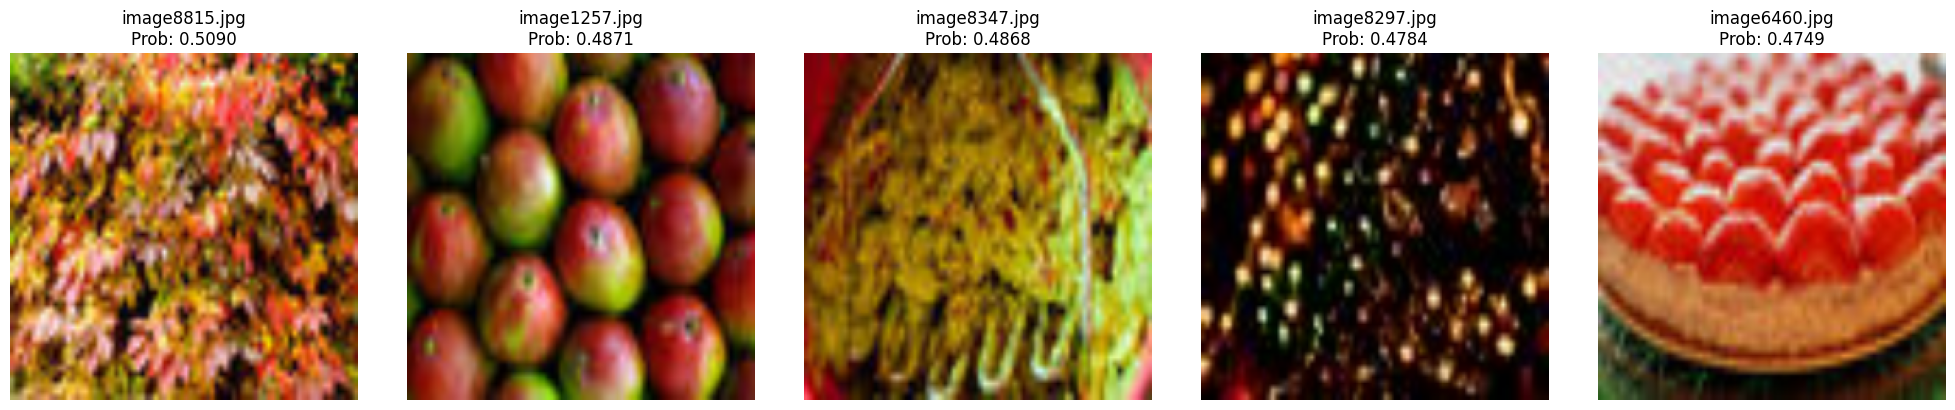


Top 5 predictions:
1. image8815.jpg - Probability: 0.5090
2. image1257.jpg - Probability: 0.4871
3. image8347.jpg - Probability: 0.4868
4. image8297.jpg - Probability: 0.4784
5. image6460.jpg - Probability: 0.4749


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader (same as before)
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


# Testing on the new images
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array for easier handling
all_scores_np = np.array(all_scores)

# Get indices of top 5 highest probabilities
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Plot top 5 images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
if len(top_indices) < 5:
    fig, axes = plt.subplots(1, len(top_indices), figsize=(20, 4))

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print top 5 predictions
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

#### VGG 19

In [9]:
# VGG19 with BatchNorm Model
model = models.vgg19_bn(weights=models.VGG19_BN_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 223MB/s] 
Epoch 1/1: 100%|██████████| 66/66 [00:46<00:00,  1.43it/s]

Epoch 1, Loss: 0.0179


test

Testing: 100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


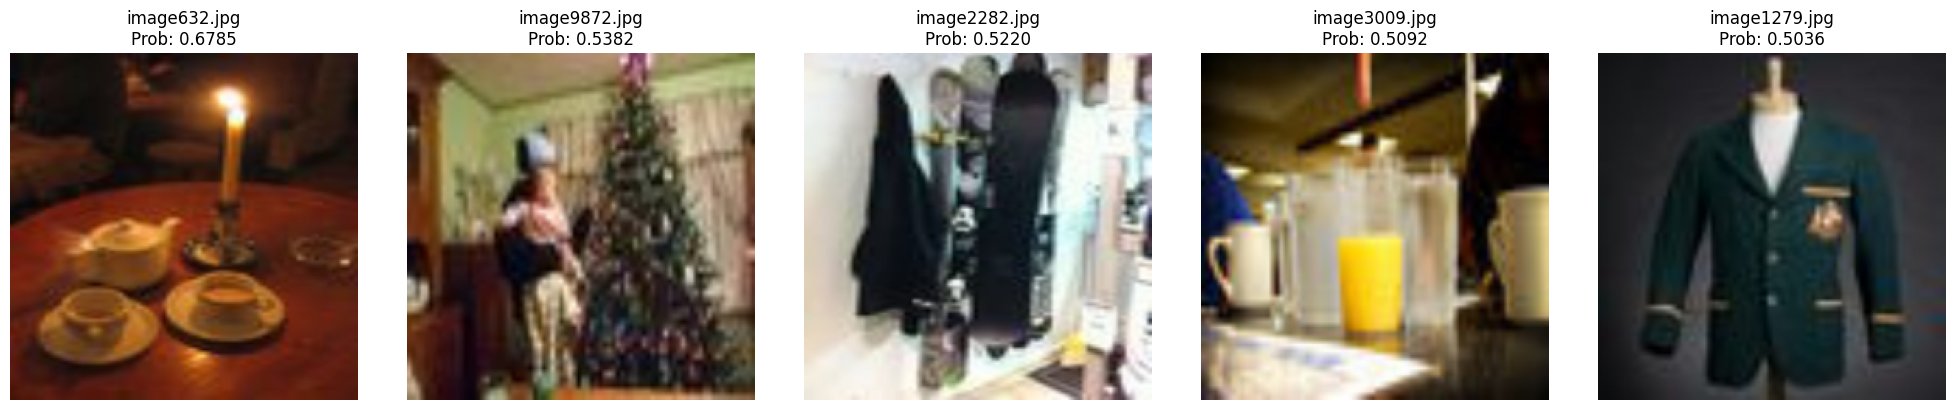


Top 5 predictions:
1. image632.jpg - Probability: 0.6785
2. image9872.jpg - Probability: 0.5382
3. image2282.jpg - Probability: 0.5220
4. image3009.jpg - Probability: 0.5092
5. image1279.jpg - Probability: 0.5036


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

# Define transforms
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset and loader
test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Testing loop
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array
all_scores_np = np.array(all_scores)

# Get top predictions
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Visualization
fig, axes = plt.subplots(1, min(5, len(top_indices)), figsize=(20, 4))
if len(top_indices) == 1:
    axes = [axes]

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print results
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

## Cow

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import torchvision
from PIL import Image


# Free up memory
torch.cuda.empty_cache()
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Dataset and DataLoader classes (same as before)
class VOCCowClassification(Dataset):
    def __init__(self, root, year, image_set, transform=None):
        self.voc = torchvision.datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True,
                                transforms=lambda img, target: (transform(img), target))
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, target = self.voc[idx]
        objs = target['annotation']['object']
        if not isinstance(objs, list):
            objs = [objs]
        label = 1 if any(o['name'] == 'cow' for o in objs) else 0
        img_id = target['annotation']['filename']
        return img, label, img_id

class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Data Loaders
num_workers = min(2, os.cpu_count() // 2)
train_ds = VOCCowClassification(root='.', year='2008', image_set='train', transform=transform_train)
test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=num_workers)

Using device: cuda
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


VIT Large

In [12]:
# Vision Transformer Large (ViT_L_16) Model
from torchvision.models import vit_l_16, ViT_L_16_Weights
weights = ViT_L_16_Weights.IMAGENET1K_V1
model = vit_l_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 202MB/s] 
Epoch 1/1: 100%|██████████| 66/66 [04:03<00:00,  3.69s/it]

Epoch 1, Loss: 0.0042


test

Testing: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


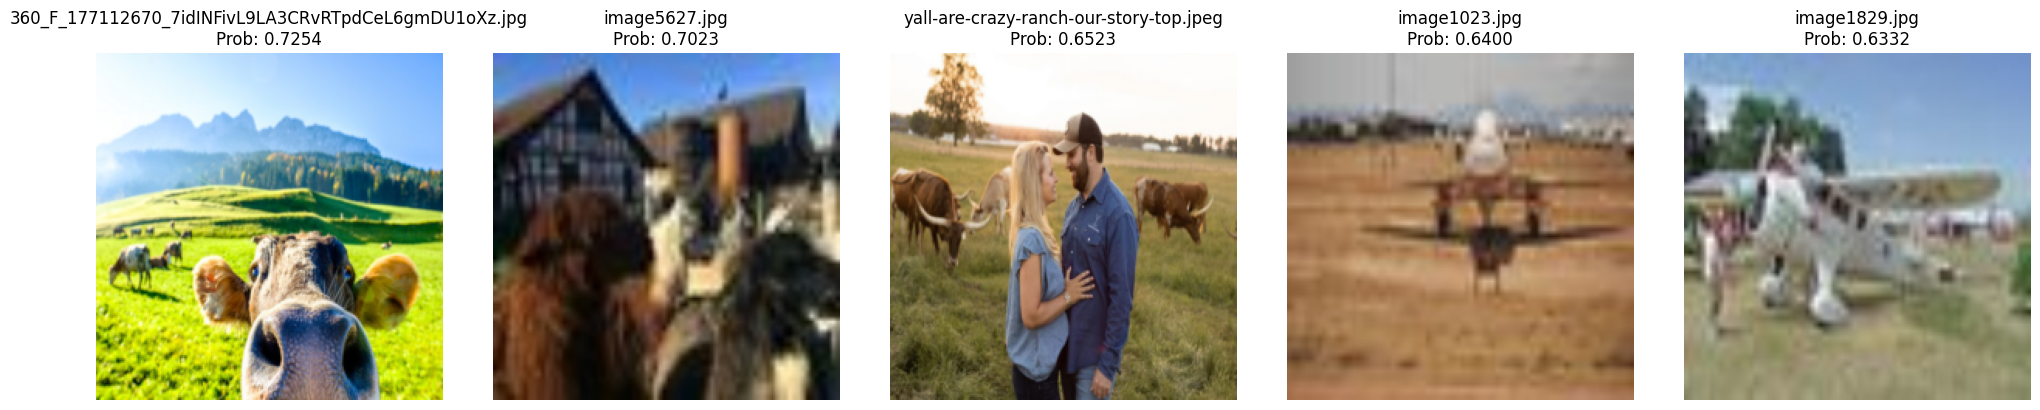


Top 5 predictions:
1. 360_F_177112670_7idINFivL9LA3CRvRTpdCeL6gmDU1oXz.jpg - Probability: 0.7254
2. image5627.jpg - Probability: 0.7023
3. yall-are-crazy-ranch-our-story-top.jpeg - Probability: 0.6523
4. image1023.jpg - Probability: 0.6400
5. image1829.jpg - Probability: 0.6332


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

# Define transforms
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset and loader
test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Testing loop
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array
all_scores_np = np.array(all_scores)

# Get top predictions
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Visualization
fig, axes = plt.subplots(1, min(5, len(top_indices)), figsize=(20, 4))
if len(top_indices) == 1:
    axes = [axes]

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print results
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

ResNet50

In [14]:
# ResNet50 Model
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


# # Save the trained model
# save_path = '/kaggle/working/resnet50_cow_classifier.pth'
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': epochs,
# }, save_path)

# print(f"Model saved to {save_path}")

Epoch 1/10: 100%|██████████| 66/66 [00:22<00:00,  2.92it/s]


Epoch 1, Loss: 0.0170


Epoch 2/10: 100%|██████████| 66/66 [00:23<00:00,  2.81it/s]


Epoch 2, Loss: 0.0053


Epoch 3/10: 100%|██████████| 66/66 [00:22<00:00,  2.89it/s]


Epoch 3, Loss: 0.0035


Epoch 4/10: 100%|██████████| 66/66 [00:22<00:00,  2.93it/s]


Epoch 4, Loss: 0.0030


Epoch 5/10: 100%|██████████| 66/66 [00:22<00:00,  2.90it/s]


Epoch 5, Loss: 0.0020


Epoch 6/10: 100%|██████████| 66/66 [00:22<00:00,  2.88it/s]


Epoch 6, Loss: 0.0018


Epoch 7/10: 100%|██████████| 66/66 [00:22<00:00,  2.90it/s]


Epoch 7, Loss: 0.0013


Epoch 8/10: 100%|██████████| 66/66 [00:22<00:00,  2.90it/s]


Epoch 8, Loss: 0.0009


Epoch 9/10: 100%|██████████| 66/66 [00:22<00:00,  2.91it/s]


Epoch 9, Loss: 0.0011


Epoch 10/10: 100%|██████████| 66/66 [00:22<00:00,  2.89it/s]

Epoch 10, Loss: 0.0012


test

Testing: 100%|██████████| 110/110 [00:18<00:00,  5.79it/s]


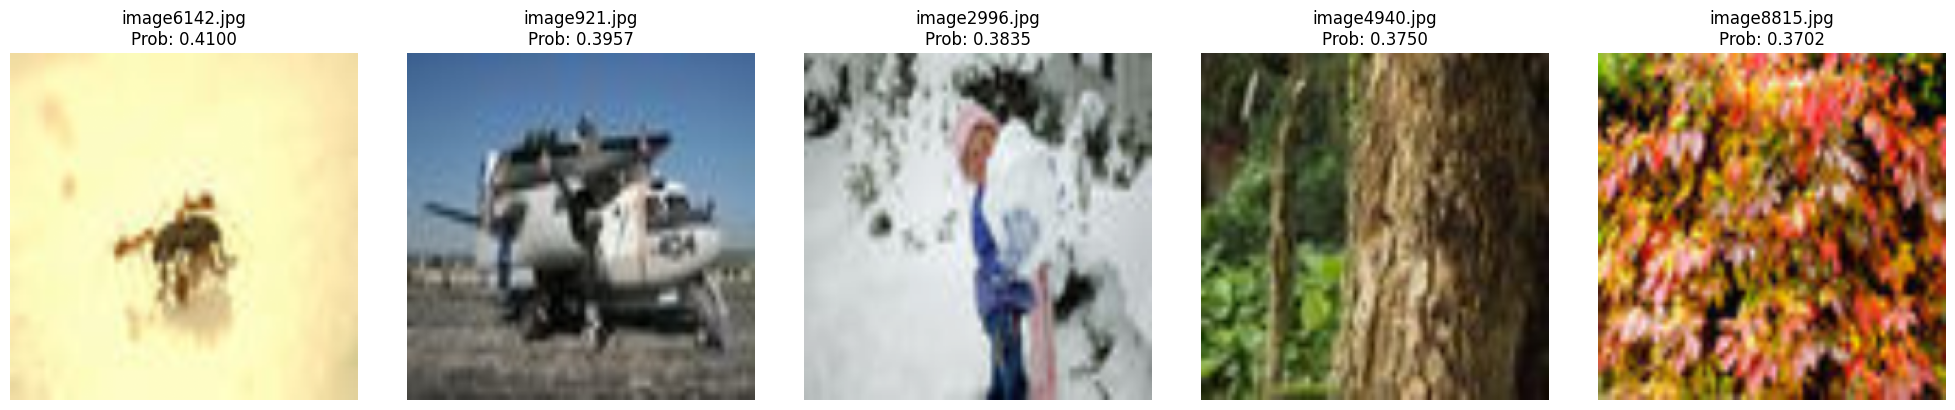


Top 5 predictions:
1. image6142.jpg - Probability: 0.4100
2. image921.jpg - Probability: 0.3957
3. image2996.jpg - Probability: 0.3835
4. image4940.jpg - Probability: 0.3750
5. image8815.jpg - Probability: 0.3702


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader (same as before)
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# # Load the saved model
# model = resnet50(weights=None)
# model.fc = nn.Linear(model.fc.in_features, 1)
# model = model.to(device)

# # Load the checkpoint
# checkpoint = torch.load('/kaggle/working/resnet50_cow_classifier.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

# Testing on the new images
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array for easier handling
all_scores_np = np.array(all_scores)

# Get indices of top 5 highest probabilities
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Plot top 5 images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
if len(top_indices) < 5:
    fig, axes = plt.subplots(1, len(top_indices), figsize=(20, 4))

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print top 5 predictions
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

#### VIT base

In [16]:
# Vision Transformer Base (ViT_B_16) Model
from torchvision.models import vit_b_16, ViT_B_16_Weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, 1)
model = model.to(device)

# Custom Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = BinaryFocalLoss(gamma=2, alpha=0.25)

# Optimizer + Scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


# Save the trained model
save_path = '/kaggle/working/VITBase_cow_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
}, save_path)

print(f"Model saved to {save_path}")


Epoch 1/1: 100%|██████████| 66/66 [01:16<00:00,  1.16s/it]


Epoch 1, Loss: 0.0068
Model saved to /kaggle/working/VITBase_cow_classifier.pth


test

Testing: 100%|██████████| 110/110 [00:47<00:00,  2.34it/s]


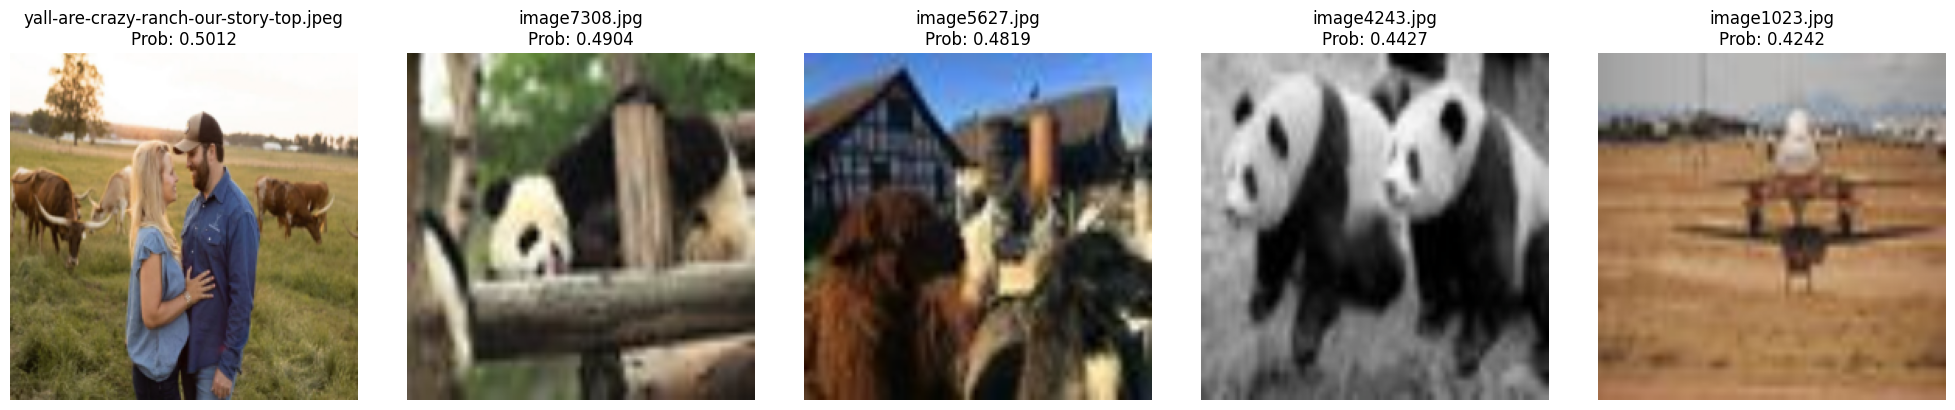


Top 5 predictions:
1. yall-are-crazy-ranch-our-story-top.jpeg - Probability: 0.5012
2. image7308.jpg - Probability: 0.4904
3. image5627.jpg - Probability: 0.4819
4. image4243.jpg - Probability: 0.4427
5. image1023.jpg - Probability: 0.4242


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from torchvision.models.vision_transformer import vit_b_16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the test dataset and loader
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.image_files[idx]

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_ds = TestImageDataset(root_dir='/kaggle/input/crazy-test1/test', transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Initialize the model
model = vit_b_16(weights=None)  # Start with no pretrained weights
model.heads.head = nn.Linear(model.heads.head.in_features, 1)
model = model.to(device)

# Load the checkpoint
checkpoint_path = '/kaggle/working/VITBase_cow_classifier.pth'
try:
    # Try loading with weights_only=True first (more secure)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
except:
    # Fall back to unsafe loading if necessary (with warning)
    import warnings
    warnings.warn("Using unsafe model loading - only do this with trusted checkpoints")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# Load the state dictionary
if isinstance(checkpoint, dict):
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
else:
    state_dict = checkpoint

# Handle potential key mismatches (like 'module.' prefix from DataParallel)
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix
    else:
        new_state_dict[k] = v

model.load_state_dict(new_state_dict)
model.eval()

# Testing on the new images
all_scores = []
all_images = []
all_img_ids = []

with torch.no_grad():
    for inputs, img_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs)).squeeze(1).cpu().numpy()

        all_scores.extend(outputs)
        all_images.extend(inputs.cpu())
        all_img_ids.extend(img_ids)

# Convert to numpy array for easier handling
all_scores_np = np.array(all_scores)

# Get indices of top 5 highest probabilities
top_indices = np.argsort(-all_scores_np)[:5]

# Define unnormalize transform
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Plot top 5 images
fig, axes = plt.subplots(1, min(5, len(top_indices)), figsize=(20, 4))
if len(top_indices) == 1:
    axes = [axes]  # Make it iterable if only one image

for ax, idx in zip(axes, top_indices):
    img = all_images[idx]
    img = unnormalize(img)
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    ax.imshow(img_np)
    ax.set_title(f"{all_img_ids[idx]}\nProb: {all_scores_np[idx]:.4f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print top 5 predictions
print("\nTop 5 predictions:")
for i, idx in enumerate(top_indices, 1):
    print(f"{i}. {all_img_ids[idx]} - Probability: {all_scores_np[idx]:.4f}")

### Fusion

for bottle

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, models
# from torchvision.datasets import VOCDetection
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# from sklearn.metrics import average_precision_score
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import os
# import gc
# import matplotlib.pyplot as plt
# import torchvision
# from torchvision.models import vit_b_16, ViT_B_16_Weights, resnet50, ResNet50_Weights, vgg19_bn, VGG19_BN_Weights

# # Setup device and directories
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.makedirs('saved_models', exist_ok=True)

# # Free up memory
# torch.cuda.empty_cache()
# gc.collect()

# class VOCBottleClassification(Dataset):
#     def __init__(self, root, year, image_set, transform=None):
#         self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True,
#                               transforms=lambda img, target: (transform(img), target))
#         self.transform = transform

#     def __len__(self):
#         return len(self.voc)

#     def __getitem__(self, idx):
#         img, target = self.voc[idx]
#         objs = target['annotation']['object']
#         if not isinstance(objs, list):
#             objs = [objs]
#         label = 1 if any(o['name'] == 'bottle' for o in objs) else 0
#         img_id = target['annotation']['filename']
#         return img, label, img_id

# class BinaryFocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
#         super().__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction
#         self.bce = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce(inputs, targets)
#         probs = torch.sigmoid(inputs)
#         pt = torch.where(targets == 1, probs, 1 - probs)
#         focal_term = (1 - pt) ** self.gamma
#         loss = self.alpha * focal_term * BCE_loss
#         return loss.mean() if self.reduction == 'mean' else loss

# class FeatureExtractor(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
        
#         # Handle different model architectures
#         if isinstance(model, torchvision.models.VisionTransformer):
#             # For ViT, we'll use the encoder's output
#             self.features = model.encoder
#         elif isinstance(model, torchvision.models.ResNet):
#             # For ResNet, use everything except the final fc layer
#             self.features = nn.Sequential(*list(model.children())[:-1])
#         elif isinstance(model, torchvision.models.VGG):
#             # For VGG, use the features part
#             self.features = model.features
#             self.pool = nn.AdaptiveAvgPool2d((1, 1))
#             self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         if isinstance(self.model, torchvision.models.VisionTransformer):
#             # ViT expects (batch, seq_len, hidden_dim)
#             x = self.model._process_input(x)
#             batch_class_token = self.model.class_token.expand(x.shape[0], -1, -1)
#             x = torch.cat([batch_class_token, x], dim=1)
#             x = self.features(x)
#             return x[:, 0]  # Return class token
#         elif isinstance(self.model, torchvision.models.ResNet):
#             features = self.features(x)
#             return torch.flatten(features, 1)
#         elif isinstance(self.model, torchvision.models.VGG):
#             features = self.features(x)
#             pooled = self.pool(features)
#             return self.flatten(pooled)

# class EarlyFusionNN(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1)
#         )
        
#     def forward(self, x):
#         return self.fc(x)

# def save_model(model, model_idx):
#     """Save the full model"""
#     torch.save(model.state_dict(), f'saved_models/model_{model_idx}_full.pth')
#     print(f"Saved model {model_idx}")


# def load_models():
#     models = []
#     feature_extractors = []
#     model_configs = [
#         {'type': 'vit', 'weights': ViT_B_16_Weights.IMAGENET1K_V1},
#         {'type': 'resnet', 'weights': ResNet50_Weights.IMAGENET1K_V1},
#         {'type': 'vgg', 'weights': VGG19_BN_Weights.IMAGENET1K_V1}
#     ]
    
#     for i, config in enumerate(model_configs):
#         # Initialize model
#         if config['type'] == 'vit':
#             model = vit_b_16(weights=None)
#             model.heads.head = nn.Linear(model.heads.head.in_features, 1)
#         elif config['type'] == 'resnet':
#             model = resnet50(weights=None)
#             model.fc = nn.Linear(model.fc.in_features, 1)
#         elif config['type'] == 'vgg':
#             model = vgg19_bn(weights=None)
#             model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
        
#         # Load model state dict
#         model.load_state_dict(torch.load(f'saved_models/model_{i}_full.pth'))
#         model = model.to(device).eval()
        
#         # Create feature extractor from loaded model
#         fe = FeatureExtractor(model).to(device).eval()
        
#         models.append(model)
#         feature_extractors.append(fe)
    
#     return models, feature_extractors

# def extract_features_and_predictions(loader, feature_extractors, models):
#     all_features = [[] for _ in feature_extractors]
#     all_predictions = [[] for _ in models]
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels, _ in tqdm(loader):
#             inputs = inputs.to(device)
#             for i, (fe, model) in enumerate(zip(feature_extractors, models)):
#                 features = fe(inputs)
#                 preds = torch.sigmoid(model(inputs)).squeeze(1).cpu()
#                 all_features[i].append(features.cpu())
#                 all_predictions[i].append(preds)
#             all_labels.append(labels)
    
#     return [torch.cat(f, dim=0) for f in all_features], [torch.cat(p, dim=0) for p in all_predictions], torch.cat(all_labels, dim=0)

# def majority_vote(preds, threshold=0.5):
#     binary_preds = (preds > threshold).astype(int)
#     return (np.mean(binary_preds, axis=1) > 0.5).astype(int)

# def average_fusion(preds): return np.mean(preds, axis=1)
# def max_fusion(preds): return np.max(preds, axis=1)
# def min_fusion(preds): return np.min(preds, axis=1)

# # Transforms
# transform_train = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform_val = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Data Loaders
# train_ds = VOCBottleClassification(root='.', year='2008', image_set='train', transform=transform_train)
# val_ds = VOCBottleClassification(root='.', year='2008', image_set='val', transform=transform_val)
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=min(2, os.cpu_count() // 2))
# val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=min(2, os.cpu_count() // 2))

# # Only run this block if you need to train models from scratch
# models_to_train = [
#     {'model': 'ViT_B_16', 'epochs': 5, 'weights': ViT_B_16_Weights.IMAGENET1K_V1},
#     {'model': 'ResNet50', 'epochs': 10, 'weights': ResNet50_Weights.IMAGENET1K_V1},
#     {'model': 'VGG19_BN', 'epochs': 5, 'weights': VGG19_BN_Weights.IMAGENET1K_V1}
# ]

# for model_idx, config in enumerate(models_to_train):
#     print(f"\nTraining {config['model']} (Model {model_idx+1}/{len(models_to_train)})")
    
#     if config['model'] == 'ViT_B_16':
#         model = vit_b_16(weights=config['weights'])
#         model.heads.head = nn.Linear(model.heads.head.in_features, 1)
#     elif config['model'] == 'ResNet50':
#         model = resnet50(weights=config['weights'])
#         model.fc = nn.Linear(model.fc.in_features, 1)
#     elif config['model'] == 'VGG19_BN':
#         model = vgg19_bn(weights=config['weights'])
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
    
#     model = model.to(device)
#     criterion = BinaryFocalLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=3e-5)
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    
#     for epoch in range(config['epochs']):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
#             inputs, labels = inputs.to(device), labels.float().to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs).squeeze(1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         scheduler.step()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
#     feature_extractor = FeatureExtractor(model)
#     save_model(model, model_idx)

# # Load models and extract features
# print("\nLoading models for fusion...")
# models, feature_extractors = load_models()
# train_features, train_preds, train_labels = extract_features_and_predictions(train_loader, feature_extractors, models)
# val_features, val_preds, val_labels = extract_features_and_predictions(val_loader, feature_extractors, models)

# # Early Fusion
# X_train_early = torch.cat(train_features, dim=1).numpy()
# X_val_early = torch.cat(val_features, dim=1).numpy()
# y_train, y_val = train_labels.numpy(), val_labels.numpy()

# scaler = StandardScaler()
# X_train_early = scaler.fit_transform(X_train_early)
# X_val_early = scaler.transform(X_val_early)

# # RBF SVM
# svm = SVC(kernel='rbf', probability=True, random_state=42)
# svm.fit(X_train_early, y_train)
# svm_probs = svm.predict_proba(X_val_early)[:, 1]
# print(f"\nEarly Fusion RBF SVM mAP: {average_precision_score(y_val, svm_probs):.4f}")

# # NN Fusion
# early_nn = EarlyFusionNN(X_train_early.shape[1]).to(device)
# optimizer = optim.Adam(early_nn.parameters(), lr=1e-3)
# criterion = nn.BCEWithLogitsLoss()

# X_train_tensor = torch.FloatTensor(X_train_early).to(device)
# y_train_tensor = torch.FloatTensor(y_train).to(device)
# X_val_tensor = torch.FloatTensor(X_val_early).to(device)

# for epoch in range(10):
#     early_nn.train()
#     optimizer.zero_grad()
#     outputs = early_nn(X_train_tensor).squeeze(1)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     optimizer.step()

# early_nn.eval()
# with torch.no_grad():
#     nn_probs = torch.sigmoid(early_nn(X_val_tensor)).squeeze().cpu().numpy()
#     print(f"Early Fusion NN mAP: {average_precision_score(y_val, nn_probs):.4f}")

# # Late Fusion
# val_preds_np = [p.numpy() for p in val_preds]
# val_preds_stack = np.stack(val_preds_np, axis=1)

# print("\nLate Fusion Results:")
# for name, method in zip(['Majority Vote', 'Average', 'Max', 'Min'], 
#                        [majority_vote, average_fusion, max_fusion, min_fusion]):
#     if name == 'Majority Vote':
#         mAP = average_precision_score(y_val, method(val_preds_stack))
#     else:
#         mAP = average_precision_score(y_val, method(val_preds_stack))
#     print(f"{name}: {mAP:.4f}")


# # Visualization
# print("\nVisualizing top predictions...")
# all_scores = val_preds[0].numpy()
# top_indices = np.argsort(-all_scores)[:10]

# unnormalize = transforms.Normalize(
#     mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
#     std=[1/s for s in [0.229, 0.224, 0.225]]
# )

# val_images = []
# with torch.no_grad():
#     for inputs, _, _ in val_loader:
#         val_images.extend(inputs.cpu())

# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for ax, idx in zip(axes.flatten(), top_indices):
#     img = unnormalize(val_images[idx]).clamp(0, 1).permute(1, 2, 0).numpy()
#     ax.imshow(img)
#     ax.set_title(f"Prob: {all_scores[idx]:.2f}\nLabel: {y_val[idx]}")
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

Cow

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, models
# from torchvision.datasets import VOCDetection
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# from sklearn.metrics import average_precision_score
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import os
# import gc
# import matplotlib.pyplot as plt
# import torchvision
# from torchvision.models import (
#     vit_l_16, ViT_L_16_Weights,
#     vit_b_16, ViT_B_16_Weights,
#     resnet50, ResNet50_Weights
# )

# # Free up memory
# torch.cuda.empty_cache()
# gc.collect()

# # Use GPU 1 explicitly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Create directory for saved models
# os.makedirs('saved_models', exist_ok=True)

# class VOCCowClassification(Dataset):
#     def __init__(self, root, year, image_set, transform=None):
#         self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True,
#                                 transforms=lambda img, target: (transform(img), target))
#         self.transform = transform

#     def __len__(self):
#         return len(self.voc)

#     def __getitem__(self, idx):
#         img, target = self.voc[idx]
#         objs = target['annotation']['object']
#         if not isinstance(objs, list):
#             objs = [objs]
#         label = 1 if any(o['name'].lower() == 'cow' for o in objs) else 0
#         img_id = target['annotation']['filename']
#         return img, label, img_id

# class BinaryFocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
#         super(BinaryFocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction
#         self.bce = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce(inputs, targets)
#         probs = torch.sigmoid(inputs)
#         pt = torch.where(targets == 1, probs, 1 - probs)
#         focal_term = (1 - pt) ** self.gamma
#         loss = self.alpha * focal_term * BCE_loss
#         return loss.mean() if self.reduction == 'mean' else loss

# class FeatureExtractor(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model
        
#         if isinstance(model, torchvision.models.VisionTransformer):
#             # For ViT models in newer PyTorch versions
#             self.features = model.encoder
#             self.class_token = model.class_token
#             self.pos_embed = model.encoder.pos_embedding  # Changed from pos_embedding to pos_embed
#             self.patch_embed = model.conv_proj  # Handles patch embedding
#         elif isinstance(model, torchvision.models.ResNet):
#             # For ResNet
#             self.features = nn.Sequential(*list(model.children())[:-1])
#         elif isinstance(model, torchvision.models.VGG):
#             # For VGG
#             self.features = model.features
#             self.pool = nn.AdaptiveAvgPool2d((1, 1))
#             self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         if isinstance(self.model, torchvision.models.VisionTransformer):
#             # Process ViT input for newer versions
#             x = self.patch_embed(x)  # [B, C, H, W] -> [B, num_patches, embed_dim]
#             x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
            
#             # Add class token and position embedding
#             batch_class_token = self.class_token.expand(x.shape[0], -1, -1)
#             x = torch.cat([batch_class_token, x], dim=1)
#             x = x + self.pos_embed
            
#             # Pass through encoder
#             x = self.features(x)
#             return x[:, 0]  # Return class token
#         elif isinstance(self.model, torchvision.models.ResNet):
#             features = self.features(x)
#             return torch.flatten(features, 1)
#         elif isinstance(self.model, torchvision.models.VGG):
#             features = self.features(x)
#             pooled = self.pool(features)
#             return self.flatten(pooled)
        
#     def forward(self, x):
#         if isinstance(self.model, torchvision.models.VisionTransformer):
#             # Process ViT input for newer versions
#             x = self.patch_embed(x)  # [B, C, H, W] -> [B, num_patches, embed_dim]
#             x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
            
#             # Add class token and position embedding
#             batch_class_token = self.class_token.expand(x.shape[0], -1, -1)
#             x = torch.cat([batch_class_token, x], dim=1)
#             x = x + self.pos_embed
            
#             # Pass through encoder
#             x = self.features(x)
#             return x[:, 0]  # Return class token
#         elif isinstance(self.model, torchvision.models.ResNet):
#             features = self.features(x)
#             return torch.flatten(features, 1)
#         elif isinstance(self.model, torchvision.models.VGG):
#             features = self.features(x)
#             pooled = self.pool(features)
#             return self.flatten(pooled)

# class EarlyFusionNN(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 1)
#         )
        
#     def forward(self, x):
#         return self.fc(x)

# def save_model(model, model_idx):
#     torch.save(model.state_dict(), f'saved_models/model_{model_idx}_full.pth')
#     print(f"Saved model {model_idx}")

# def load_models():
#     models = []
#     feature_extractors = []
    
#     model_configs = [
#         {'type': 'vit_l', 'weights': ViT_L_16_Weights.IMAGENET1K_V1},
#         {'type': 'resnet', 'weights': ResNet50_Weights.IMAGENET1K_V1},
#         {'type': 'vit_b', 'weights': ViT_B_16_Weights.IMAGENET1K_V1}
#     ]
    
#     for i, config in enumerate(model_configs):
#         if config['type'] == 'vit_l':
#             model = vit_l_16(weights=None)
#             model.heads.head = nn.Linear(model.heads.head.in_features, 1)
#         elif config['type'] == 'resnet':
#             model = resnet50(weights=None)
#             model.fc = nn.Linear(model.fc.in_features, 1)
#         elif config['type'] == 'vit_b':
#             model = vit_b_16(weights=None)
#             model.heads.head = nn.Linear(model.heads.head.in_features, 1)
        
#         # Load model with weights_only=True for security
#         model.load_state_dict(torch.load(f'saved_models/model_{i}_full.pth', 
#                                        map_location=device,
#                                        weights_only=True))
#         model = model.to(device).eval()
        
#         # Create feature extractor
#         fe = FeatureExtractor(model).to(device).eval()
#         feature_extractors.append(fe)
#         models.append(model)
    
#     return models, feature_extractors


# def extract_features_and_predictions(loader, feature_extractors, models):
#     all_features = [[] for _ in range(len(feature_extractors))]
#     all_predictions = [[] for _ in range(len(models))]
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels, _ in tqdm(loader):
#             inputs = inputs.to(device)
#             for i, (fe, model) in enumerate(zip(feature_extractors, models)):
#                 features = fe(inputs)
#                 preds = torch.sigmoid(model(inputs)).squeeze(1).cpu()
#                 all_features[i].append(features.cpu())
#                 all_predictions[i].append(preds)
#             all_labels.append(labels)
    
#     return [torch.cat(f, dim=0) for f in all_features], [torch.cat(p, dim=0) for p in all_predictions], torch.cat(all_labels, dim=0)

# def majority_vote(preds, threshold=0.5):
#     binary_preds = (preds > threshold).astype(int)
#     return (np.mean(binary_preds, axis=1) > 0.5).astype(int)

# def average_fusion(preds): return np.mean(preds, axis=1)
# def max_fusion(preds): return np.max(preds, axis=1)
# def min_fusion(preds): return np.min(preds, axis=1)

# # Transforms
# transform_train = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform_val = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Data Loaders
# train_ds = VOCCowClassification(root='.', year='2008', image_set='train', transform=transform_train)
# val_ds = VOCCowClassification(root='.', year='2008', image_set='val', transform=transform_val)

# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=min(2, os.cpu_count() // 2))
# val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=min(2, os.cpu_count() // 2))

# # Train models
# models_to_train = [
#     {'model': 'ViT_L_16', 'epochs': 5, 'weights': ViT_L_16_Weights.IMAGENET1K_V1},
#     {'model': 'ResNet50', 'epochs': 10, 'weights': ResNet50_Weights.IMAGENET1K_V1},
#     {'model': 'ViT_B_16', 'epochs': 5, 'weights': ViT_B_16_Weights.IMAGENET1K_V1}
# ]

# for model_idx, config in enumerate(models_to_train):
#     print(f"\nTraining {config['model']} (Model {model_idx+1}/{len(models_to_train)})")
    
#     if config['model'] == 'ViT_L_16':
#         model = vit_l_16(weights=config['weights'])
#         model.heads.head = nn.Linear(model.heads.head.in_features, 1)
#     elif config['model'] == 'ResNet50':
#         model = resnet50(weights=config['weights'])
#         model.fc = nn.Linear(model.fc.in_features, 1)
#     elif config['model'] == 'ViT_B_16':
#         model = vit_b_16(weights=config['weights'])
#         model.heads.head = nn.Linear(model.heads.head.in_features, 1)
    
#     model = model.to(device)
#     criterion = BinaryFocalLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=3e-5)
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    
#     for epoch in range(config['epochs']):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
#             inputs, labels = inputs.to(device), labels.float().to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs).squeeze(1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         scheduler.step()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
#     save_model(model, model_idx)

# # Load models and perform fusion
# print("\nLoading models for fusion...")
# models, feature_extractors = load_models()
# train_features, train_preds, train_labels = extract_features_and_predictions(train_loader, feature_extractors, models)
# val_features, val_preds, val_labels = extract_features_and_predictions(val_loader, feature_extractors, models)

# # Early Fusion
# X_train_early = torch.cat(train_features, dim=1).numpy()
# X_val_early = torch.cat(val_features, dim=1).numpy()
# y_train = train_labels.numpy()
# y_val = val_labels.numpy()

# scaler = StandardScaler()
# X_train_early = scaler.fit_transform(X_train_early)
# X_val_early = scaler.transform(X_val_early)

# # RBF SVM
# svm = SVC(kernel='rbf', probability=True, random_state=42)
# svm.fit(X_train_early, y_train)
# svm_probs = svm.predict_proba(X_val_early)[:, 1]
# print(f"\nEarly Fusion RBF SVM mAP: {average_precision_score(y_val, svm_probs):.4f}")

# # NN Fusion
# early_nn = EarlyFusionNN(X_train_early.shape[1]).to(device)
# optimizer = optim.Adam(early_nn.parameters(), lr=1e-3)
# criterion = nn.BCEWithLogitsLoss()

# X_train_tensor = torch.FloatTensor(X_train_early).to(device)
# y_train_tensor = torch.FloatTensor(y_train).to(device)
# X_val_tensor = torch.FloatTensor(X_val_early).to(device)

# for epoch in range(10):
#     early_nn.train()
#     optimizer.zero_grad()
#     outputs = early_nn(X_train_tensor).squeeze(1)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
#     optimizer.step()

# early_nn.eval()
# with torch.no_grad():
#     outputs = early_nn(X_val_tensor).squeeze(1)
#     nn_probs = torch.sigmoid(outputs).cpu().numpy()
#     print(f"Early Fusion NN mAP: {average_precision_score(y_val, nn_probs):.4f}")

# # Late Fusion
# val_preds_np = [p.numpy() for p in val_preds]
# val_preds_stack = np.stack(val_preds_np, axis=1)

# print("\nLate Fusion Results:")
# for name, method in zip(['Majority Vote', 'Average', 'Max', 'Min'], 
#                        [majority_vote, average_fusion, max_fusion, min_fusion]):
#     if name == 'Majority Vote':
#         fused_preds = method(val_preds_stack)
#         mAP = average_precision_score(y_val, fused_preds)
#     else:
#         fused_probs = method(val_preds_stack)
#         mAP = average_precision_score(y_val, fused_probs)
#     print(f"{name}: {mAP:.4f}")

# # Visualization
# print("\nVisualizing top predictions...")
# all_scores = val_preds[0].numpy()
# top_indices = np.argsort(-all_scores)[:10]

# unnormalize = transforms.Normalize(
#     mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
#     std=[1/s for s in [0.229, 0.224, 0.225]]
# )

# val_images = []
# with torch.no_grad():
#     for inputs, _, _ in val_loader:
#         val_images.extend(inputs.cpu())

# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# for ax, idx in zip(axes.flatten(), top_indices):
#     img = unnormalize(val_images[idx]).clamp(0, 1).permute(1, 2, 0).numpy()
#     ax.imshow(img)
#     ax.set_title(f"Prob: {all_scores[idx]:.2f}\nLabel: {y_val[idx]}")
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

